In [1]:
from elasticsearch import Elasticsearch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
es = Elasticsearch([{"host": "localhost", "port": 9200, "scheme": "http"}], basic_auth=('elastic', 'CbIxwM6z85Dm6fKtAJte'))
index_name = "reuters"

In [3]:
print(es.ping())

True


### Top-10 mentioned georeferences across the entire index

Top-10 Georeferences: (['U.S.', 'Japan', 'New York', 'Canada', 'London', 'the United States', 'Washington', 'Brazil', 'West Germany', 'Britain'], [665, 177, 127, 113, 111, 109, 105, 96, 89, 84])


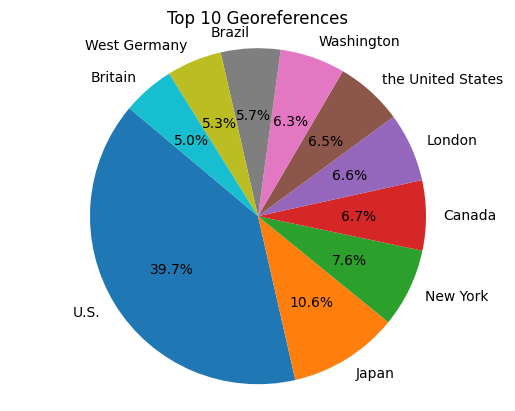

In [9]:
def top_georeferences(index_name, es):
    """
    Retrieves the top georeferences from the specified Elasticsearch index.

    Args:
        index_name (str): Name of the Elasticsearch index.
        es: Elasticsearch client instance.

    Returns:
        tuple: A tuple containing two lists - top georeferences and their corresponding counts.
    """
    search_query = {
        "size": 0,
        "aggs": {
            "top_georeferences": {
                "nested": {
                    "path": "georeferences"
                },
                "aggs": {
                    "georeference_terms": {
                        "terms": {
                            "field": "georeferences.expression.keyword", 
                            "size": 10
                        }
                    }
                }
            }
        }
    }

    results = es.search(index=index_name, body=search_query)
    top_georeferences_buckets = results["aggregations"]["top_georeferences"]["georeference_terms"]["buckets"]
    
    top_georeferences = [bucket["key"] for bucket in top_georeferences_buckets]
    counts = [bucket["doc_count"] for bucket in top_georeferences_buckets]
    
    return top_georeferences, counts

def plot_top_georeferences_pie(top_georeferences_result):
    """
    Plots a pie chart for the top georeferences.

    Args:
        top_georeferences_result (tuple): A tuple containing two lists - top georeferences and their corresponding counts.

    Returns:
        None
    """
    labels, counts = top_georeferences_result

    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Top 10 Georeferences')

    # Show the plot
    plt.show()

# Example usage:
top_georeferences_result = top_georeferences(index_name, es)
print("Top-10 Georeferences:", top_georeferences_result)

# Plotting the results using a pie chart
plot_top_georeferences_pie(top_georeferences_result)


### Retrieves documents over time 

Total number of documents: 5262


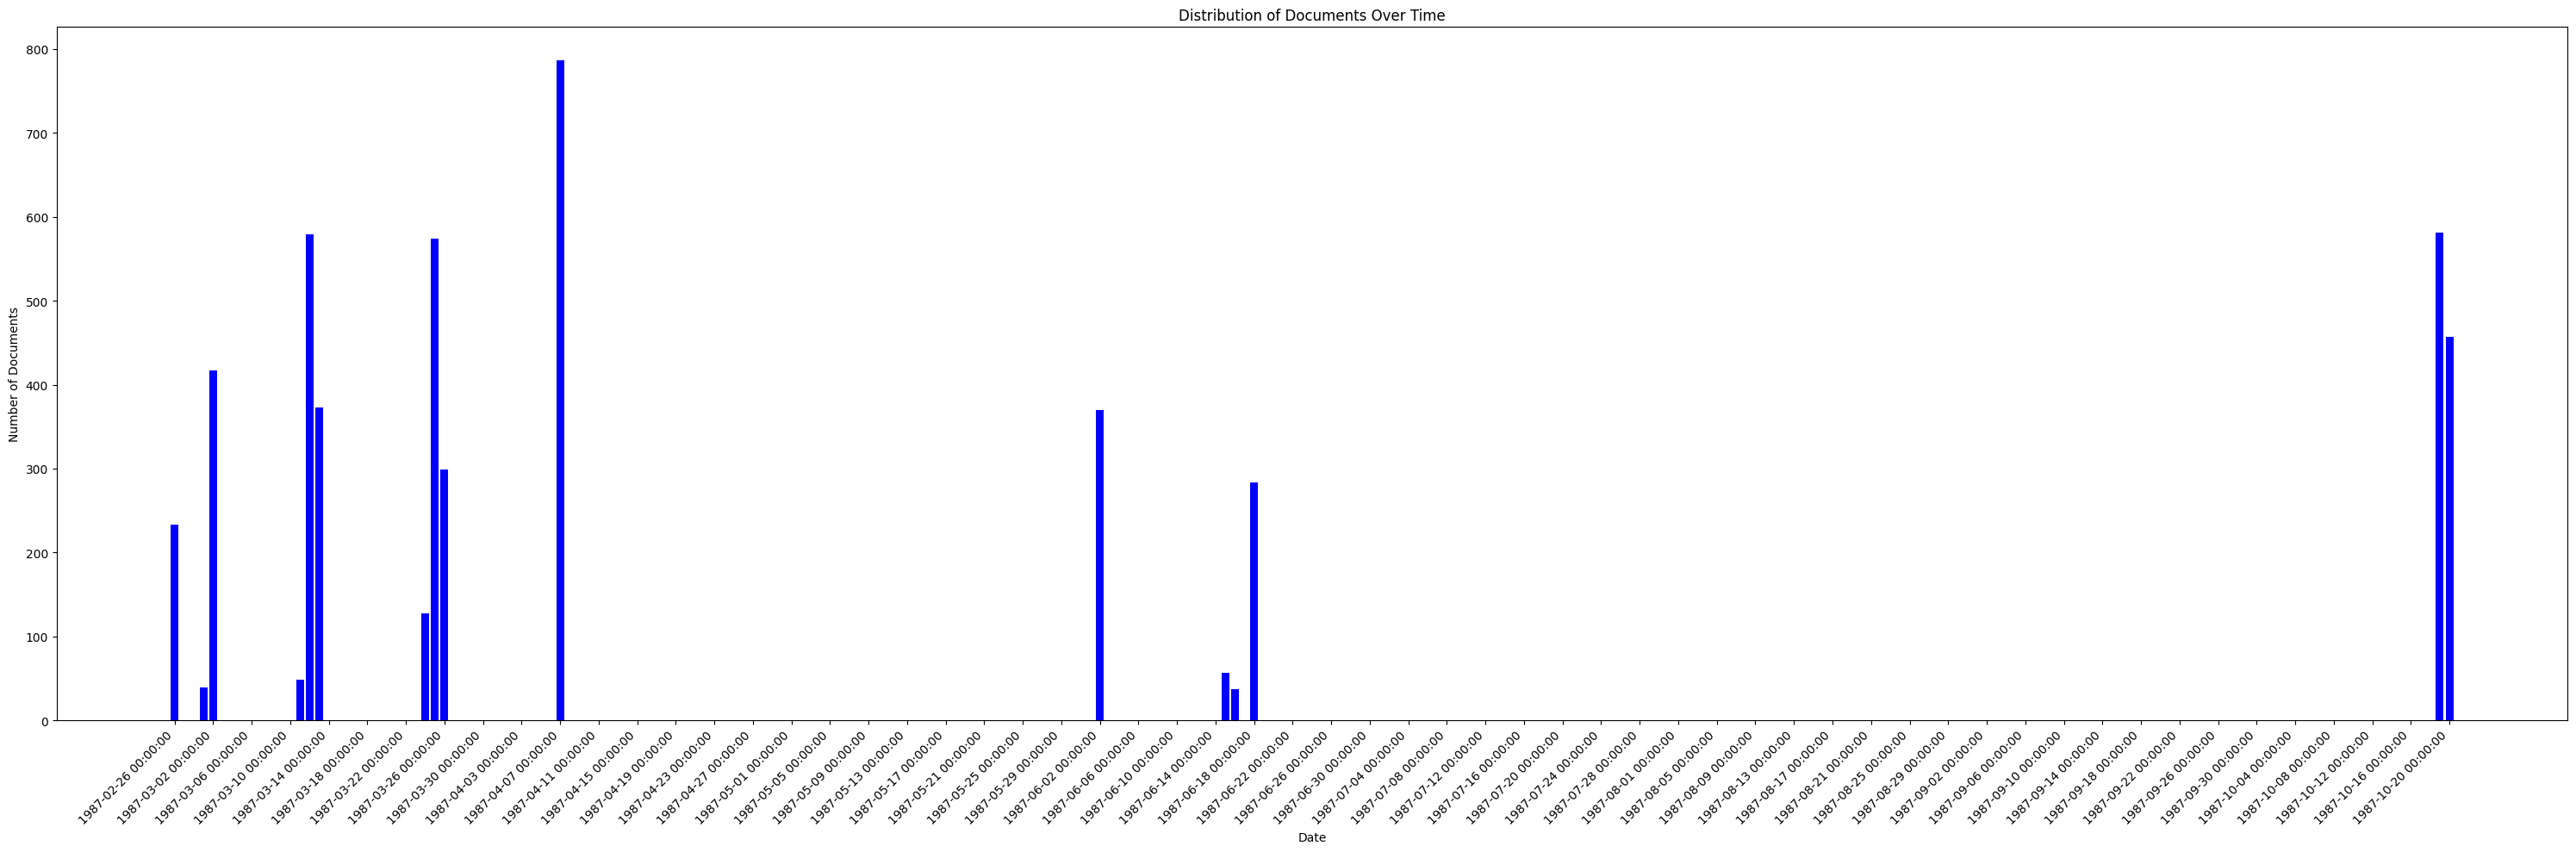

In [10]:
def get_documents_over_time(index_name, date_field="date", es=None):
    """
    Retrieves documents over time from the specified Elasticsearch index.

    Args:
        index_name (str): Name of the Elasticsearch index.
        date_field (str): Field containing the date information.
        es: Elasticsearch client instance.

    Returns:
        list: List of dictionaries containing date histogram buckets.
    """
    # Define the aggregation query
    aggregation_query = {
        "size": 0,
        "aggs": {
            "documents_over_time": {
                "date_histogram": {
                    "field": date_field,
                    "fixed_interval": "1d",
                    "format": "yyyy-MM-dd HH:mm:ss",
                    "min_doc_count": 0
                }
            }
        }
    }

    # Execute the query
    result = es.search(index=index_name, body=aggregation_query)

    # Extract and return the aggregation results
    return result["aggregations"]["documents_over_time"]["buckets"]

# Example usage
result = get_documents_over_time(index_name, es=es)

# Extract data for plotting
dates = [bucket['key_as_string'] for bucket in result]
document_counts = [bucket['doc_count'] for bucket in result]
# Calculate the total number of documents
total_documents = sum(bucket['doc_count'] for bucket in result)

# Print the total number of documents
print(f'Total number of documents: {total_documents}')

# Plotting
plt.figure(figsize=(30, 10))
plt.bar(dates, document_counts, color='b')
plt.title('Distribution of Documents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Documents')

# Display only a subset of dates for better readability
every_nth = 4
plt.xticks(np.arange(0, len(dates), every_nth), [dates[i] for i in range(0, len(dates), every_nth)], rotation=45, ha='right')

plt.tight_layout()
plt.show()